# Base Pytorch Model Implementation

In [1]:
# Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import Food101
import matplotlib.pyplot as plt

/home/cpsc552/miniconda3/envs/cpsc552/lib/python3.12/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
def main():
    # Use GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_transform =  transforms.Compose([
        transforms.RandomResizedCrop(size = 224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    #Test does not use augmentation, only normalization is being performed.
    test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Set the directory for saving the dataset
    # data_dir = '/content/drive/My Drive/FinalProject1'
    data_dir = './data'

    # Load datasets, first time you need to download it (may take a while). After that it should just pull the local copy
    train_dataset = datasets.Food101(root=data_dir, split='train', download=True, transform=train_transform)
    test_dataset = datasets.Food101(root=data_dir, split='test', download=True, transform=test_transform)

    # Dataloaders, may need to change # of workers or batchsize to improve performance
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,num_workers=4)

    # Pretrained model, efficient architecture
    model = models.efficientnet_b2(weights='DEFAULT')

    # If false, then pretrained weights do not change
    # for val in model.features.parameters():
    #   val.requires_grad = False

    # Add one more layer to base model and then add an output layer
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier[1].in_features, 1024),
        nn.ReLU(),
        nn.Linear(1024, len(train_dataset.classes))
    )

    print("Loading model")
    # Path to the .pth file
    model_path = 'results/bestmodel.pth'

    # Load the state dictionary from the .pth file
    state_dict = torch.load(model_path)

    # Load the state dictionary into the model
    model.load_state_dict(state_dict)

    # Put model onto gpu
    model = model.to(device)

    # Set optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_function = nn.CrossEntropyLoss()
    # Train model for # of epochs
    for epoch in range(1):
        # Put model in training setting
        model.train()
        # Track best accuracy
        best_acc = 0
        for inputs, labels in train_loader:
            # Put data on device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Zero out gradient
            optimizer.zero_grad()
            # Get output of model
            outputs = model(inputs)
            # Calculate loss
            loss = loss_function(outputs, labels)
            # Propogate loss and update model
            loss.backward()
            optimizer.step()
        print("Epoch: " + str((epoch+1)) + "  Loss: " + str(loss.item()))

        # Test accuracy of model
        # Put model in evaluation setting
        model.eval()
        correct_id = 0
        total = 0
        # Disable gradient update during testing
        with torch.no_grad():
            for inputs, labels in test_loader:
                # Put data on device
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Get output of model
                outputs = model(inputs)
                # Get predicted label
                _, predicted_labels = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct_id += (predicted_labels == labels).sum().item()

        acc = (100 * correct_id) / total
        # Save best vesion of model at save_path
        if(acc > best_acc):
          best_acc = acc
          # save_path = "/content/drive/My Drive/model.pth"
          save_path = "./results/bestmodel.pth"
          torch.save(model.state_dict(), save_path)

        print("Validation Accuracy: " + str(acc))

if __name__ == '__main__':
    main()

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /home/cpsc552/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 40.3MB/s]


Loading model
Epoch: 1  Loss: 0.7592591643333435
Validation Accuracy: 79.66336633663366


#Adversarial Examples

###Adversarial Examples Algorithm

In [ ]:
#  pip
!pip install torchattacks

#  source
!pip install git+https://github.com/Harry24k/adversarial-attacks-pytorch.git

#  git clone
!git clone https://github.com/Harry24k/adversarial-attacks-pytorch.git
!cd adversarial-attacks-pytorch/
!pip install -e

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
# from torchattacks import PGD

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
#dataset

# Define transforms for preprocessing the data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.Food101(root='./data', download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)


/tmp/ipykernel_3408049/2138538115.py:7: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  plt.imshow(img.T)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(29)


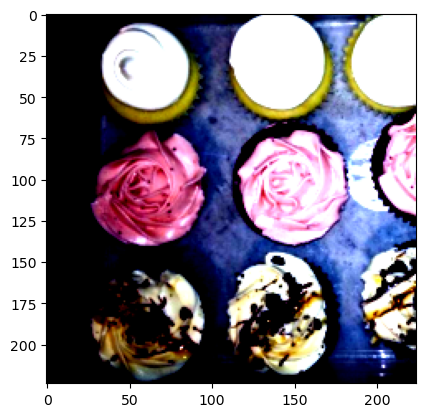

In [7]:


# Display image and label.
train_features, train_labels = next(iter(trainloader))
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.T)
print(label)
plt.show()


In [ ]:
#model
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=101):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
#adversarial training

# Define your neural network
net = SimpleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Adversarial training parameters
epsilon = 0.3  # Magnitude of perturbation
alpha = 0.01   # Step size for PGD attack
num_steps = 10  # Number of steps for PGD attack

repeats = 1

# Adversarial training loop
for epoch in range(1):  # Number of epochs
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        if i > repeats:
          break

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Assuming GPU availability

        #print(inputs.shape)

        # Adversarial perturbation using PGD
        adversary = PGD(net, eps=epsilon, alpha=alpha, steps=num_steps)
        adv_inputs = adversary(inputs, labels)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(adv_inputs)
        outputs = outputs.to(device)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 10 == 9:  # Print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')


Finished Training


tensor(48)


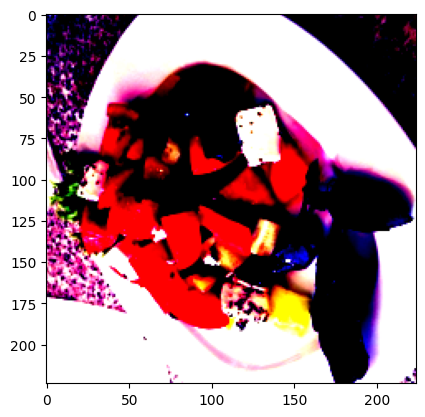

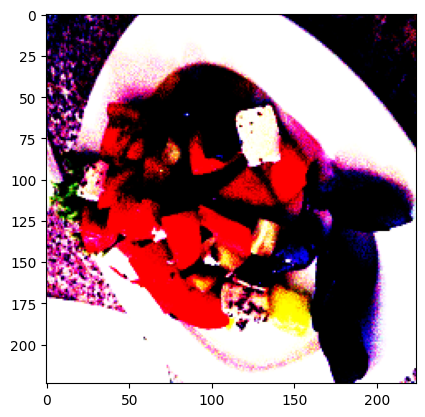

In [ ]:
# Display image and label.
img = inputs[0].squeeze()
img_adv = adv_inputs[0].squeeze()
label = labels[0]

print(label)

plt.imshow(img.T)
plt.show()
plt.imshow(img_adv.T)
plt.show()

###Attack

In [9]:
def general_PGD(model, loss_function, data, proj_norm=2, radius=0.03, lr=0.01, steps=10):

  features, labels = data
  features = features.clone().detach().to(device)
  labels = labels.clone().detach().to(device)

  adv_features = features.clone().detach()

  #maximize loss wrt feature perturbations, for fixed network parameters
  for i in range(steps):
    adv_features.requires_grad = True

    #model prediction
    pred = model(adv_features)

    #error calculation
    error = loss_function(pred, labels)

    #gradient descend
    grad = torch.autograd.grad(error, adv_features)[0] #grad:(1, 64, 3, 224, 224), where the first coordinate if the batch number?
    grad_norm = torch.norm(grad, p=proj_norm, dim=[1,2,3]) #normalize the gradient according to paper https://arxiv.org/pdf/1706.06083
    grad = grad / grad_norm.view(-1,1,1,1)

    adv_features = adv_features.detach() + lr * grad

    #projection: |features - adv_features|_{norm} < radius
    orig_diff = features - adv_features
    orig_diff_norm = torch.norm(orig_diff, p=proj_norm, dim=[1,2,3])
    normalization = radius / orig_diff_norm

    diff = orig_diff * normalization.view(-1,1,1,1)

    adv_features = (features - diff).detach()

  return adv_features


###Random Tests

In [12]:
# Pretrained model, efficient architecture
model = models.efficientnet_b2(weights='DEFAULT')

# If false, then pretrained weights do not change
# for val in model.features.parameters():
#   val.requires_grad = False

# Add one more layer to base model and then add an output layer
model.classifier = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 1024),
    nn.ReLU(),
    nn.Linear(1024, len(trainset.classes))
)

print("Loading model")
# Path to the .pth file
model_path = 'results/bestmodel.pth'

# Load the state dictionary from the .pth file
state_dict = torch.load(model_path)

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Put model onto gpu
model = model.to(device)

loss_function = nn.CrossEntropyLoss()
proj_norm=2
lr=0.001
radius=0.01
data = next(iter(trainloader))

NameError: name 'train_dataset' is not defined

In [11]:
features, labels = data
adv_features = features
adv_features.requires_grad = True

#model prediction
pred = model.forward(adv_features)

#error calculation
error = loss_function(pred, labels-1) #for nn.CrossEntropy, pred must be the raw logits, labels must be [0,C-1], C: #classes

#gradient descend
grad = torch.autograd.grad(error, adv_features)[0] #grad:(1, 64, 3, 224, 224), where the first coordinate if the batch number?
grad_norm = torch.norm(grad, p=proj_norm, dim=[1,2,3]) #normalize the gradient according to paper https://arxiv.org/pdf/1706.06083
grad = grad / grad_norm.view(-1,1,1,1)

adv_features = adv_features.detach() + lr * grad

#projection: |features - adv_features|_{norm} < radius
orig_diff = features - adv_features
orig_diff_norm = torch.norm(orig_diff, p=proj_norm, dim=[1,2,3])
normalization = radius / orig_diff_norm

diff = orig_diff * normalization.view(-1,1,1,1)

adv_features = (features - diff).detach()

NameError: name 'model' is not defined

In [ ]:
import numpy as np
np.shape(grad_norm)

torch.Size([64])

In [ ]:
torch.norm(grad,p=2)

tensor(1.0001)

In [ ]:
pred2 = pred.detach().numpy()
print(labels, np.argmax(pred2, axis=1))

In [ ]:
# Display image and label.
#features = features.detach().numpy()
#adv_features = adv_features.detach().numpy()
img = features[0].squeeze()
img_adv = adv_features[0].squeeze()

label = labels[0]
print(label, pred)

plt.imshow(img.T)
plt.show()
plt.imshow(img_adv.T)
plt.show()

TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
